In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
DEMAND_DATA = os.path.join("/Users/andika/Desktop/PROJECT/MACHINELEARNING/datasets", "housing")
EXPLORATORY_SAMPLE = 0.05

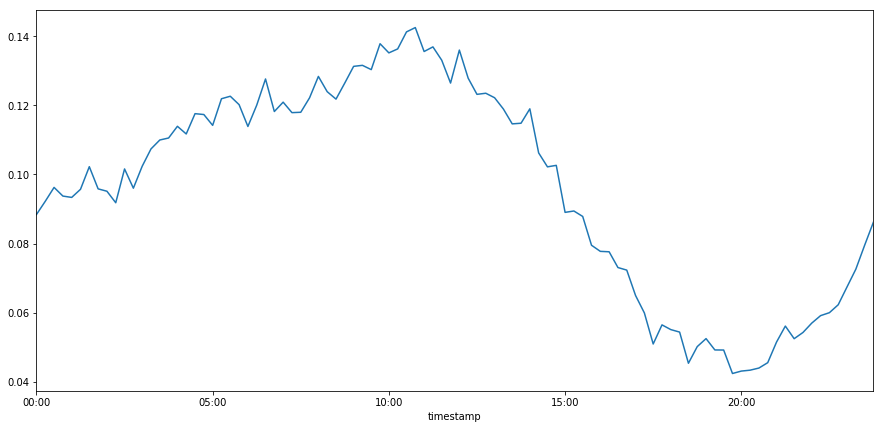

In [2]:
def load_data(path=DEMAND_DATA):
    csv_path = os.path.join(path, "GRAB_traffic_data_training.csv")
    return pd.read_csv(csv_path)

def zero_padding_timestamp(x):
    h,m = map(str,x.split(':'))
    h = h.zfill(2)
    m = m.rjust(2,'0')
    return h+":"+m

def feature_hour(x):
    h,m = map(str,x.split(':'))
    return float(h)


traffic_all = load_data()
traffic_all['hour'] = traffic_all['timestamp'].apply(feature_hour)
traffic_all['timestamp'] = traffic_all['timestamp'].apply(zero_padding_timestamp)

#create small set for quick analysis
#traffic_toy = traffic_all.sample(frac =.05) 
traffic_all = traffic_all.sample(frac = EXPLORATORY_SAMPLE) 

#plotting mean of hourly data
fig, ax = plt.subplots(figsize=(15,7))
traffic_all.groupby('timestamp').mean()['demand'].plot(kind='line')


We observed a high level of demand starting 5AM, peaking at 10AM. This is expected since those 
are the time where people are in a hurry for work.

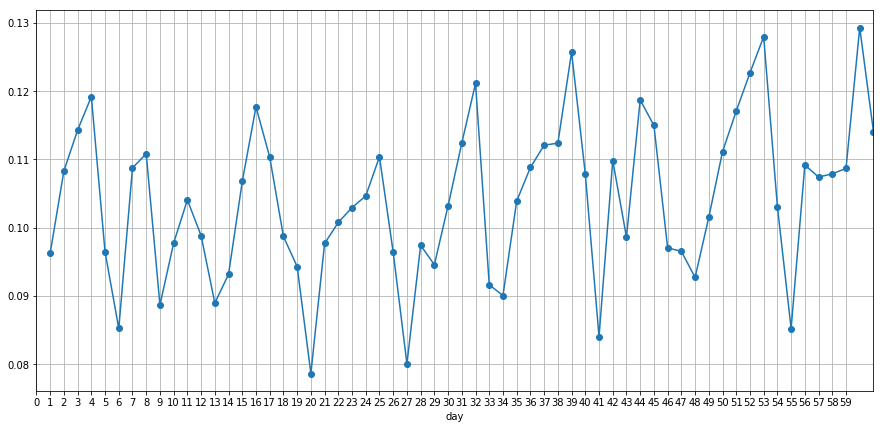

In [3]:
#investigate daily/weekly pattern
fig, ax = plt.subplots(figsize=(15,7))
daily_ticks = 1*np.arange(60)
traffic_all.groupby(['day']).mean()['demand'].plot(kind='line',xticks=daily_ticks,marker='o',grid=True)

Although we are not sure the exact day, we can see a strong pattern in term of cyclical days, suspected to be weekly.
Lowest demand is consistently on day 6,13,20,...55, the 6th day of week, possibly Sunday or Saturday
High demand is on 4,11,18,25... 60. the 4th day of the week, possibly Friday or Monday

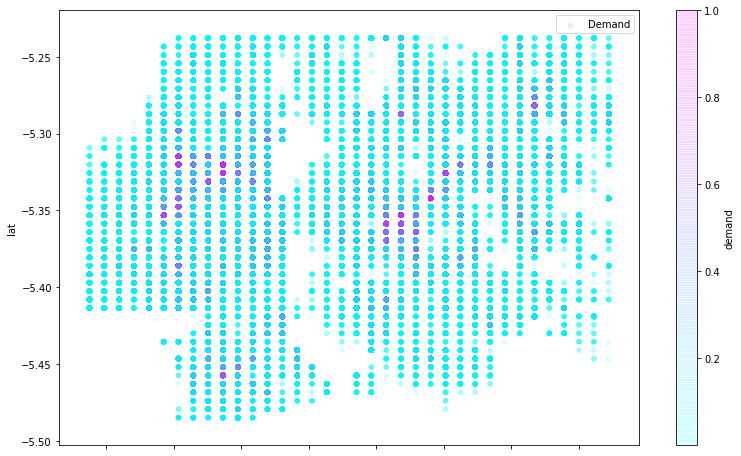

In [4]:
import geohash

def feature_lat(x):
    return geohash.decode(x)[0]

def feature_long(x):
    return geohash.decode(x)[1]

traffic_all['lat'] = traffic_all['geohash6'].apply(feature_lat)
traffic_all['long'] = traffic_all['geohash6'].apply(feature_long)
traffic_all = traffic_all.dropna()

#traffic_all.plot(kind="scatter", x="long", y="lat", alpha=0.1)

traffic_all.plot(kind="scatter", x="long", y="lat", alpha=0.1, label="Demand", figsize=(13,8),
    c="demand", cmap=plt.get_cmap("cool"), colorbar=True
)

There are several clusters of hotspots in the data set. 

In [5]:
traffic_all["day_of_week"] = traffic_all.apply(lambda x: x.day%7, axis=1)

#look for correlation based on the features we added
corr_matrix = traffic_all.corr()
corr_matrix["demand"].sort_values(ascending=False)

demand         1.000000
day            0.020510
lat           -0.020212
day_of_week   -0.020885
long          -0.028847
hour          -0.084969
Name: demand, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a38e47d30>,
      dtype=object)

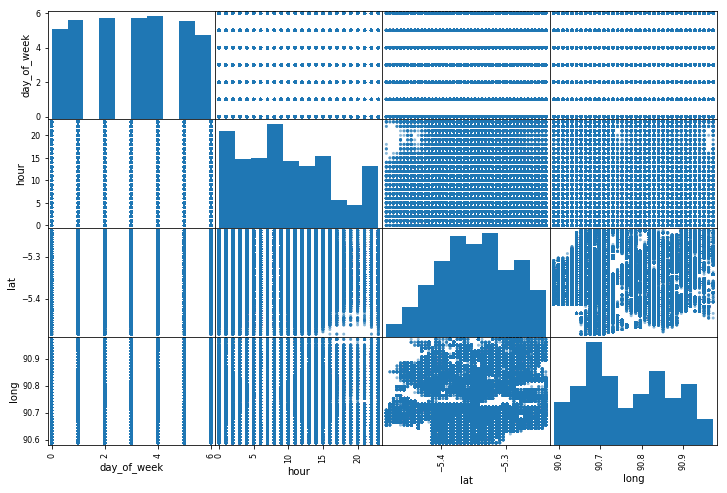

In [6]:
from pandas.plotting import scatter_matrix
attributes = ["day_of_week", "hour", "lat", "long"]
scatter_matrix(traffic_all[attributes], figsize=(12, 8))

There doesn't seem to be significant correlation between the attributes here.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210316 entries, 1579287 to 1254879
Data columns (total 8 columns):
geohash6       210316 non-null object
day            210316 non-null int64
timestamp      210316 non-null object
demand         210316 non-null float64
hour           210316 non-null float64
lat            210316 non-null float64
long           210316 non-null float64
day_of_week    210316 non-null int64
dtypes: float64(4), int64(2), object(2)
memory usage: 14.4+ MB


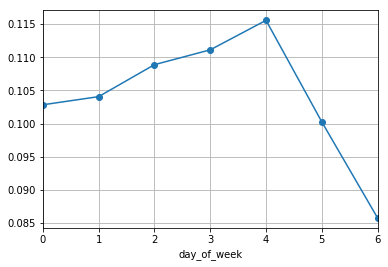

In [7]:
traffic_all.info()
traffic_all.groupby(['day_of_week']).mean()['demand'].plot(kind='line',marker='o',grid=True)

The graph above seems to indicate that the daily count start from 0=Monday.
I am expecting Saturday and Sunday to be on low demand because most passenger will not be as active.
Assume day_of_week=5, 6 to be weekend

In [8]:
def feature_weekday_weekend(x):
    if(x == 5 or x == 6):
        return 1
    return 0

traffic_all['weekend'] = traffic_all['day_of_week'].apply(feature_weekday_weekend)
traffic_all.head(n=5)

,geohash6,day,timestamp,demand,hour,lat,long,day_of_week,weekend
1579287,qp09kb,41,13:30,0.002216,13.0,-5.402527,90.917358,6,1
3061144,qp09s9,45,22:15,0.023809,22.0,-5.353088,90.906372,3,0
890699,qp03q1,14,23:15,0.056129,23.0,-5.397034,90.620728,0,0
78877,qp03zc,4,09:00,0.159255,9.0,-5.309143,90.697632,4,0
473302,qp0d53,57,14:30,0.045753,14.0,-5.265198,90.851440,1,0


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is depreca

Number of clusters: 583


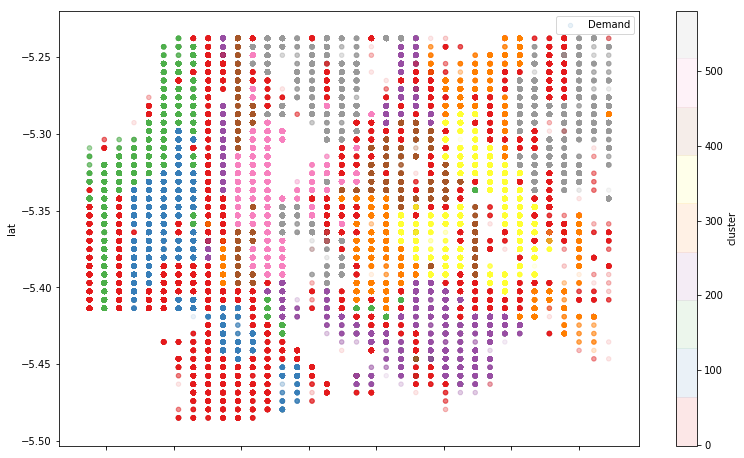

In [9]:
import hdbscan

coords = traffic_all.as_matrix(columns=['lat', 'long'])

kms_per_radian = 6371.0088
epsilon = 1.22 / kms_per_radian
db = hdbscan.HDBSCAN(min_cluster_size=200, min_samples=20,  metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

traffic_all['cluster'] = db.labels_.tolist()

traffic_all.plot(kind="scatter", x="long", y="lat", alpha=0.1, label="Demand", figsize=(13,8),
    c="cluster", cmap=plt.get_cmap("Set1"), colorbar=True)


Using visual inspection, the clustering result above doesn't really yield useful feature in terms of demand forecasting so we will be dropping it.

In [10]:
traffic_all.drop(columns='cluster')

,geohash6,day,timestamp,demand,hour,lat,long,day_of_week,weekend
1579287,qp09kb,41,13:30,0.002216,13.0,-5.402527,90.917358,6,1
3061144,qp09s9,45,22:15,0.023809,22.0,-5.353088,90.906372,3,0
890699,qp03q1,14,23:15,0.056129,23.0,-5.397034,90.620728,0,0
78877,qp03zc,4,09:00,0.159255,9.0,-5.309143,90.697632,4,0
473302,qp0d53,57,14:30,0.045753,14.0,-5.265198,90.851440,1,0
2240799,qp09f7,20,07:30,0.029669,7.0,-5.298157,90.807495,6,1
1938319,qp03x0,34,03:00,0.004860,3.0,-5.358582,90.664673,6,1
2269977,qp03xq,1,02:00,0.090923,2.0,-5.325623,90.675659,1,0
1696610,qp09vj,49,16:15,0.013536,16.0,-5.287170,90.928345,0,0
2099796,qp03mc,18,00:30,0.038888,0.0,-5.397034,90.609741,4,0


Start building and test various Scikit Learn algorithm

In [11]:
traffic_all.head()
traffic_all = traffic_all[['geohash6','day','timestamp','hour','lat','long','day_of_week','weekend','demand']]
traffic_all.head()

,geohash6,day,timestamp,hour,lat,long,day_of_week,weekend,demand
1579287,qp09kb,41,13:30,13.0,-5.402527,90.917358,6,1,0.002216
3061144,qp09s9,45,22:15,22.0,-5.353088,90.906372,3,0,0.023809
890699,qp03q1,14,23:15,23.0,-5.397034,90.620728,0,0,0.056129
78877,qp03zc,4,09:00,9.0,-5.309143,90.697632,4,0,0.159255
473302,qp0d53,57,14:30,14.0,-5.265198,90.851440,1,0,0.045753


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error

#We take hour, lat, long, day_of_week and weekend for the training data
traffic_data = traffic_all.iloc[:, 3:-1].values
traffic_label = traffic_all.iloc[:, -1].values

xTrain, xTest, yTrain, yTest = train_test_split(traffic_data, traffic_label, test_size = 1/3, random_state = 0)

#adjusted to 60 and 450 based on GridSearchCV result
rf_regressor = RandomForestRegressor(max_depth=60,  n_estimators=450)
rf_regressor.fit(X=xTrain,y=yTrain)

y_reg_test_predict = rf_regressor.predict(xTest)

print("RandomForestRegressor MSE:", mean_squared_error(yTest, y_reg_test_predict))

feature_importances = rf_regressor.feature_importances_.argsort()[::-1][:len(rf_regressor.feature_importances_)]
print("Most important: feature "+ str(feature_importances[0]))


RandomForestRegressor MSE: 0.00316465046121419
Most important: feature 1


In [13]:
ada_regressor = AdaBoostRegressor(n_estimators=200)
ada_regressor.fit(X=xTrain,y=yTrain)

y_reg_test_predict = ada_regressor.predict(xTest)

print("AdaBoostRegressor MSE:", mean_squared_error(yTest, y_reg_test_predict))

feature_importances = ada_regressor.feature_importances_.argsort()[::-1][:len(ada_regressor.feature_importances_)]
print("Most important: feature "+ str(feature_importances[0]))

AdaBoostRegressor MSE: 0.027968159005294684
Most important: feature 1


In [14]:
dt_regressor = DecisionTreeRegressor()
dt_regressor.fit(X=xTrain,y=yTrain)

y_reg_test_predict = dt_regressor.predict(xTest)

print("DecisionTreeRegressor MSE:", mean_squared_error(yTest, y_reg_test_predict))

feature_importances = dt_regressor.feature_importances_.argsort()[::-1][:len(dt_regressor.feature_importances_)]
print("Most important: feature "+ str(feature_importances[0]))


DecisionTreeRegressor MSE: 0.004289287273610523
Most important: feature 1


In [15]:
gb_regressor = GradientBoostingRegressor()
gb_regressor.fit(X=xTrain,y=yTrain)

y_reg_test_predict = gb_regressor.predict(xTest)

print("GradientBoostingRegressor MSE:", mean_squared_error(yTest, y_reg_test_predict))

feature_importances = gb_regressor.feature_importances_.argsort()[::-1][:len(gb_regressor.feature_importances_)]
print("Most important: feature "+ str(feature_importances[0]))


GradientBoostingRegressor MSE: 0.017275749022516277
Most important: feature 1


In [16]:
hb_regressor = HuberRegressor()
hb_regressor.fit(X=xTrain,y=yTrain)

y_reg_test_predict = hb_regressor.predict(xTest)

print("HuberRegressor MSE:", mean_squared_error(yTest, y_reg_test_predict))


HuberRegressor MSE: 0.026525456208965698


Create the function to predict test set. It will rebuild the model based on the input trainingSetPath and predict on testSetPath

The dataset and features performed best on RandomForestRegressor. We try to get the best parameters.

This algorithm runs very slow, will need to do scaling given more time

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = { 
	'n_estimators': [150,300,450,600],
	'max_depth' : [20,40,80,100]
}
CV_rfc = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv= 10)
CV_rfc.fit(X=xTrain,y=yTrain)

print ("Random Forest Regressor best_params_ : " + str(CV_rfc.best_params_))
print ("Random Forest Regressor best_score_ : " + str(CV_rfc.best_score_))